In [25]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from scipy.io import netcdf

import iris
import iris.coord_categorisation
import iris.plot as iplt
import iris.quickplot as qplt

import os
import logging

import numpy as np

import pickle
from pathlib import Path
from cartopy.util import add_cyclic_point
logger = logging.getLogger(__name__)


In [26]:
def get_scenarios():
    """
        Return a List containing SCENARIO tag names
    """
    MODELS = [ 'clm', 'jules' ]
    LU_SCENARIOS = [ 'nattobiobio','nattobioaff','nattobio','nattoaff','agtonat','agtobio','agtoaff' ]
    CLIM_SCENARIOS = [ 'ssp126', 'ssp370' ]
    CLIM_MODELS = [ 'mpi-esm1-2-hr','ukesm1-0-ll','ipsl-cm6a-lr' ]
    return CLIM_SCENARIOS, CLIM_MODELS

In [27]:
def add_metadata(cube, field, fname):
    
    esm_id = fname.split('_')[1]
    ssp_id = fname.split('_')[2]

    iris.std_names.STD_NAMES['experiment_id'] = {'canonical units':'1'}
    
    #if not cube.coords("experiment_id"):
    climate_coord = iris.coords.AuxCoord(ssp_id, "experiment_id", units="1", long_name="experiment_id")
    cube.add_aux_coord(climate_coord)

    #if not cube.coords("realization"):
    esm_coord = iris.coords.AuxCoord(esm_id, "realization", units="1")
    cube.add_aux_coord(esm_coord)



In [28]:
def _get_land_fraction(cube):
    """Extract land fraction as :mod:`dask.array`."""
    fx_cube = None
    land_fraction = None
    errors = []
    
    try:
        fx_cube = cube.ancillary_variable('land_area_fraction')
    except iris.exceptions.AncillaryVariableNotFoundError:
        try:
            fx_cube = cube.ancillary_variable('sea_area_fraction')
        except iris.exceptions.AncillaryVariableNotFoundError:
            errors.append('Ancillary variables land/sea area fraction not '
                          'found in cube. Check ancillary data availability.')
            return (land_fraction, errors)

    land_fraction = fx_cube.core_data()
    
    if fx_cube.var_name == 'sftlf':
        land_fraction = fx_cube.core_data() / 100.0
    if fx_cube.var_name == 'sftof':
        land_fraction = 1.0 - fx_cube.core_data() / 100.0
    
    return (land_fraction, errors)

In [29]:
def weighting_landsea_fraction(cube, area_type):
    """Weight fields using land or sea fraction.

    This preprocessor function weights a field with its corresponding land or
    sea area fraction (value between 0 and 1). The application of this is
    important for most carbon cycle variables (and other land-surface outputs),
    which are e.g. reported in units of `kgC m-2`. This actually refers to 'per
    square meter of land/sea' and NOT 'per square meter of gridbox'. So in
    order to integrate these globally or regionally one has to both area-weight
    the quantity but also weight by the land/sea fraction.

    Parameters
    ----------
    cube : iris.cube.Cube
        Data cube to be weighted. It should have an
        :class:`iris.coords.AncillaryVariable` with standard name
        ``'land_area_fraction'`` or ``'sea_area_fraction'``. If both are
        present, only the ``'land_area_fraction'`` will be used.
    area_type : str
        Use land (``'land'``) or sea (``'sea'``) fraction for weighting.

    Returns
    -------
    iris.cube.Cube
        Land/sea fraction weighted cube.

    Raises
    ------
    TypeError
        ``area_type`` is not ``'land'`` or ``'sea'``.
    ValueError
        Land/sea fraction variables ``sftlf`` or ``sftof`` not found.
    """
    if area_type not in ('land', 'sea'):
        raise TypeError(
            f"Expected 'land' or 'sea' for area_type, got '{area_type}'")
    (land_fraction, errors) = _get_land_fraction(cube)
    if land_fraction is None:
        raise ValueError(
            f"Weighting of '{cube.var_name}' with '{area_type}' fraction "
            f"failed because of the following errors: {' '.join(errors)}")

    core_data = cube.core_data()
    if area_type == 'land':
        cube.data = core_data * land_fraction
    elif area_type == 'sea':
        cube.data = core_data * (1.0 - land_fraction)
    return cube

In [31]:
def add_ancillary_variable(cube, temp_ancil_cube):
    """Add cube as an ancillary variable in the cube containing the data.

    Parameters
    ----------
    cube: iris.cube.Cube
        Iris cube with input data.
    temp_ancil_cube: iris.cube.Cube
        Iris cube with ancillary data.

    Returns
    -------
    iris.cube.Cube
        Cube with added ancillary variables
    """
    
    cube_left_lat = cube.coord("longitude").points[0]
    cube_right_lat = cube.coord("longitude").points[-1]

    acube_left_lat = temp_ancil_cube.coord("longitude").points[0]
    acube_right_lat = temp_ancil_cube.coord("longitude").points[-1]

    if cube_left_lat != acube_left_lat:
        ancillary_cube = temp_ancil_cube.intersection(longitude=(-180,180), ignore_bounds=True )
    else:
        ancillary_cube = temp_ancil_cube
        
    ancillary_var = iris.coords.AncillaryVariable(
        ancillary_cube.core_data(),
        standard_name=ancillary_cube.standard_name,
        units=ancillary_cube.units,
        var_name=ancillary_cube.var_name,
        attributes=ancillary_cube.attributes)
    start_dim = cube.ndim - len(ancillary_var.shape)
    cube.add_ancillary_variable(ancillary_var, range(start_dim, cube.ndim))
    logger.debug('Added %s as ancillary variable in cube of %s.',
                 ancillary_cube.var_name, cube.var_name)

In [32]:
run plot_tools.ipynb

In [33]:
def map_diff(var,ssp,esm,SCENARIO_TITLES,PLOT_TITLES):
    """Map the difference between the scenario and no LUC, in terms of
    delta-C (= 2100-2015).

    Parameters
    ----------
    var: Which variable will be mapped. Valid choices are 'cSoil' or 'cVeg'
    
    scenario_title: Name of the land use scenario
    
    plot_title: Longer string for the title of the map

    Returns
    -------
    Nothing: But makes the png files
    """

    firstmap_file = Path('/bdd/ESM2025/WP10/analysis/files/clm_'+var+'_noluc_2015.pkl')
    lastmap_file = Path('/bdd/ESM2025/WP10/analysis/files/clm_'+var+'_noluc_2100.pkl')
    with open(firstmap_file, 'rb') as f:
        NOLUC_START = pickle.load(f)
    with open(lastmap_file, 'rb') as f2:
        NOLUC_END = pickle.load(f2)

    file2read = netcdf.NetCDFFile('clm_landfrac.nc','r')
    templon = file2read.variables['lon']
    templat = file2read.variables['lat']
    lats = templat[:]*1
    lons = templon[:]*1  
    
    nclim = len(esm)

    #https://kpegion.github.io/Pangeo-at-AOES/examples/multi-panel-cartopy.html
    fig, axs = plt.subplots(nrows=2,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))
    
    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    axs=axs.flatten()
    
    if var=='cSoil':
        clevs=np.arange(-3,4,1)
    else: 
        clevs=np.arange(-10,11,1)
    i=0
    for i1 in range(0,2):
        for i0 in range(0,nclim): 

            darray1 = np.array(NOLUC_END[ssp[i1]][esm[i0]])
            darray2 = np.array(NOLUC_START[ssp[i1]][esm[i0]])
            mapdata = darray1 - darray2
            #mapdata,lons=add_cyclic_point(mapdata,coord=lons)
            cs=axs[i].contourf(lons,lats,mapdata[0,], clevs,
                      transform = ccrs.PlateCarree(),
                      cmap='BrBG',extend='both')              
            axs[i].set_title(esm[i0]+", "+ssp[i1])
            axs[i].coastlines()

            i+=1
            
    # Delete the unwanted axes
    #for i in [6,7]:
    #    fig.delaxes(axs[i])    

    # Adjust the location of the subplots on the page to make room for the colorbar
    fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                        wspace=0.02, hspace=0.04)

    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

    # Draw the colorbar
    cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')

    # Add a big title at the top
    plt.suptitle('No LUC')     
    plt.savefig('figures/clm/maps/clm_noluc_'+var+'.png', 
                                    format="png")
        

    # Next plot the scenario differences.
    for i2 in range(0,5):
        scenario_title = SCENARIO_TITLES[i2]
        plot_title = PLOT_TITLES[i2]
        
        scenario_file1 = Path('/bdd/ESM2025/WP10/analysis/files/clm_'+var+'_'+scenario_title+'_2015.pkl')
        scenario_file2 = Path('/bdd/ESM2025/WP10/analysis/files/clm_'+var+'_'+scenario_title+'_2100.pkl')

        with open(scenario_file1, 'rb') as f3:
            SCENARIO_START = pickle.load(f3)
        with open(scenario_file2, 'rb') as f4:
            SCENARIO_END = pickle.load(f4)

        fig2, axs2 = plt.subplots(nrows=2,ncols=3,
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(11,8.5))
    
        # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
        axs2=axs2.flatten()
    
        if var=='cSoil':
            clevs2=np.arange(-1,1.25,0.25)
        else: 
            clevs2=np.arange(-2,2.25,0.25)
 
        i=0
        for i1 in range(0,2):
            for i0 in range(0,nclim): 

                darray1 = np.array(NOLUC_END[ssp[i1]][esm[i0]])
                darray2 = np.array(NOLUC_START[ssp[i1]][esm[i0]])

                darray3 = np.array(SCENARIO_END[ssp[i1]][esm[i0]])
                darray4 = np.array(SCENARIO_START[ssp[i1]][esm[i0]])
                mapdata_scenario = (darray3 - darray4) - (darray1 - darray2)
 
                cs=axs2[i].contourf(lons,lats,mapdata_scenario[0,], clevs2,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')              
                axs2[i].set_title(esm[i0]+", "+ssp[i1])
                axs2[i].coastlines()

                i+=1

            
        # Delete the unwanted axes
        #for i in [6,7]:
        #    fig.delaxes(axs[i])    

        # Adjust the location of the subplots on the page to make room for the colorbar
        fig2.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                            wspace=0.02, hspace=0.04)

        # Add a colorbar axis at the bottom of the graph
        cbar_ax2 = fig2.add_axes([0.2, 0.2, 0.6, 0.02])

        # Draw the colorbar
        cbar=fig2.colorbar(cs, cax=cbar_ax2,orientation='horizontal')

        # Add a big title at the top
        plt.suptitle(plot_title)     
        plt.savefig('figures/clm/maps/clm_'+scenario_title+'_'+var+'diff.png', 
                                    format="png", dpi=400)

In [54]:
def main():

    make_maps=False
    region=0

    var1='cCwd'
    var2='cLitter'
    var3='cProduct'
    
    SCENARIO_TITLES = ['agtobio', 'agtonat', 'agtoaff', 'nattobio', 'nattoaff']
    PLOT_TITLES = ['Biocrops on ag land', 'Natural regrowth on ag land', 
                   'Afforestation on ag land', 'Biocrops on natural land',
                   'Afforestation on natural land'] 

    ssp, esm = get_scenarios()
    nclim = len(esm)
    years = np.arange(2015,2101)     
    
    # First get the no land use change data
    csoil_noluc,csoil_noluc_tr,csoil_noluc_te = retrieve_data_generic(var2,'noluc','clm')
    cveg_noluc,cveg_noluc_tr,cveg_noluc_te = retrieve_data_generic(var1,'noluc','clm')
    if var3 != 'cTot':
        var3_noluc,var3_noluc_tr,var3_noluc_te = retrieve_data_generic(var3,'noluc','clm')
    
    if make_maps == True:
        map_diff(var1,ssp,esm,SCENARIO_TITLES,PLOT_TITLES)
        map_diff(var2,ssp,esm,SCENARIO_TITLES,PLOT_TITLES)
        
    #PLOT THE NO LUC SCENARIO
    scenario_title = 'noluc'
    plot_title = 'CLM No LUC'
    
    fig,axes=plt.subplots(3,1, figsize=[8,11])


    region_title=['Global','Tropics','NH-Temperate']
    # top left: cveg
    ax=axes[0]
    ax.set_ylabel(r'$\Delta$' +var1+' (PgC) '+region_title[region],fontsize=10)
    ax.set_title(plot_title,fontsize=12)
    ax.set_xlim([2015,2100])
    ax.grid(True) 
    
    #SSP126, SSP370
    colors = ('purple','orange')
    linestyles = ('-','--','-.')
    for i1 in range(0,2):
        for i0 in range(0,nclim): 
            if region==0:
                plot_cveg = cveg_noluc[ssp[i1]][esm[i0]]
            elif region==1:
                plot_cveg = cveg_noluc_tr[ssp[i1]][esm[i0]]
            elif region==2:
                plot_cveg = cveg_noluc_te[ssp[i1]][esm[i0]]               
            ax.plot(years, plot_cveg[0]-plot_cveg[0][0], label=ssp[i1]+' '+esm[i0],
                    c=colors[i1],ls=linestyles[i0],lw=2) 
            
    # top right: csoil
    ax=axes[1]
    ax.set_ylabel(r'$\Delta$' +var2+' (PgC) '+region_title[region],fontsize=10)
    ax.set_title(plot_title,fontsize=12)
    ax.set_xlim([2015,2100])
    ax.grid(True) 

    for i1 in range(0,2):
        for i0 in range(0,nclim):
            if region==0:
                plot_csoil = csoil_noluc[ssp[i1]][esm[i0]]
            elif region==1:
                plot_csoil = csoil_noluc_tr[ssp[i1]][esm[i0]]
            elif region==2:
                plot_csoil = csoil_noluc_te[ssp[i1]][esm[i0]]  

            ax.plot(years, plot_csoil[0]-plot_csoil[0][0], label=ssp[i1]+' '+esm[i0],
                    c=colors[i1],ls=linestyles[i0],lw=2)

    
    # bottom left: ctot
    ax=axes[2]
    ax.set_ylabel(r'$\Delta$' +var3+' (PgC) '+region_title[region],fontsize=10)
    ax.set_title(plot_title,fontsize=12)
    ax.set_xlim([2015,2100])
    ax.grid(True) 

    for i1 in range(0,2):
        for i0 in range(0,nclim):
            if var3=='cTot':
                if region==0:
                    plot_csoil = csoil_noluc[ssp[i1]][esm[i0]]
                    plot_cveg = cveg_noluc[ssp[i1]][esm[i0]]
                elif region==1:
                    plot_csoil = csoil_noluc_tr[ssp[i1]][esm[i0]]
                    plot_cveg = cveg_noluc_tr[ssp[i1]][esm[i0]]
                elif region==2:
                    plot_csoil = csoil_noluc_te[ssp[i1]][esm[i0]]
                    plot_cveg = cveg_noluc_te[ssp[i1]][esm[i0]]
                plotdata = (plot_csoil[0]-plot_csoil[0][0]) + (plot_cveg[0]-plot_cveg[0][0])
                ax.plot(years, plotdata, label=esm[i0],c=colors[i1],ls=linestyles[i0],lw=2)
            else:
                if region==0:
                    plot_var3 = var3_noluc[ssp[i1]][esm[i0]]
                elif region==1:
                    plot_var3 = var3_noluc_tr[ssp[i1]][esm[i0]]
                elif region==2:
                    plot_var3 = var3_noluc_te[ssp[i1]][esm[i0]] 
                ax.plot(years, plot_var3[0]-plot_var3[0][0], label=ssp[i1]+' '+esm[i0],
                        c=colors[i1],ls=linestyles[i0],lw=2)
    
    handles,labels = axes[0].get_legend_handles_labels()
    fig.legend(handles,labels,ncol=2,loc='lower center',fontsize=10)    
    if var3 == 'cTot':
        plt.savefig('figures/clm/clm_cpools_'+region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)    
    else:
        plt.savefig('figures/clm/clm_cpoolsV2_'+region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)    

#NOW GET THE LAND USE SCENARIOS AND PLOT EITHER THE DIFFERENCES OR THE RAW VALUES

    plot_diff = True
    for i2 in range(0,5):
        scenario_title = SCENARIO_TITLES[i2]
        plot_title = PLOT_TITLES[i2]
        
        csoil,csoil_tr,csoil_te = retrieve_data_generic(var2,scenario_title,'clm')
        cveg,cveg_tr,cveg_te = retrieve_data_generic(var1,scenario_title,'clm')
        if var3 != 'cTot':
            var3_glob,var3_tr,var3_te = retrieve_data_generic(var3,'noluc','clm')
           
        fig,axes=plt.subplots(3,1, figsize=[8,11])


        # top left: cveg
        ax=axes[0]
        ax.set_ylabel(r'$\Delta$' +var1+' (PgC) '+region_title[region],fontsize=10)
        if plot_diff==True:
            ax.set_title('CLM ('+plot_title+') - (no LUC scenario)',fontsize=12)
        else:
            ax.set_title('CLM '+plot_title,fontsize=12)
        ax.set_xlim([2015,2100])
        ax.grid(True) 

        
        for i1 in range(0,2):
            for i0 in range(0,nclim):
                if region==0:
                    plot_cveg = cveg[ssp[i1]][esm[i0]]
                    plot_cveg_noluc = cveg_noluc[ssp[i1]][esm[i0]]
                if region==1:
                    plot_cveg = cveg_tr[ssp[i1]][esm[i0]]
                    plot_cveg_noluc = cveg_noluc_tr[ssp[i1]][esm[i0]]
                if region==2:
                    plot_cveg = cveg_te[ssp[i1]][esm[i0]]
                    plot_cveg_noluc = cveg_noluc_te[ssp[i1]][esm[i0]]

                if plot_diff==True:
                    ax.plot(years, 
                             (plot_cveg[0]-plot_cveg[0][0]) - (plot_cveg_noluc[0]-plot_cveg_noluc[0][0]), 
                             label=ssp[i1]+' '+esm[i0],c=colors[i1],ls=linestyles[i0],lw=2)
                else:
                    ax.plot(years, (plot_cveg[0]-plot_cveg[0][0]), 
                         label=ssp[i1]+' '+esm[i0],c=colors[i1],ls=linestyles[i0],lw=2)
                   
        
        # top right: csoil
        ax=axes[1]
        ax.set_ylabel(r'$\Delta$' +var2+' (PgC) '+region_title[region],fontsize=10)
        if plot_diff==True:
            ax.set_title('CLM ('+plot_title+') - (no LUC scenario)',fontsize=12)
        else:
            ax.set_title('CLM '+plot_title,fontsize=12)
        ax.set_xlim([2015,2100])
        ax.grid(True) 

        for i1 in range(0,2):
            for i0 in range(0,nclim):
                if region==0:
                    plot_csoil = csoil[ssp[i1]][esm[i0]]
                    plot_csoil_noluc = csoil_noluc[ssp[i1]][esm[i0]]
                elif region==1:
                    plot_csoil = csoil_tr[ssp[i1]][esm[i0]]
                    plot_csoil_noluc = csoil_noluc_tr[ssp[i1]][esm[i0]]
                elif region==2:
                    plot_csoil = csoil_te[ssp[i1]][esm[i0]]
                    plot_csoil_noluc = csoil_noluc_te[ssp[i1]][esm[i0]]
                
                if plot_diff==True:
                    ax.plot(years, 
                             (plot_csoil[0]-plot_csoil[0][0]) - (plot_csoil_noluc[0]-plot_csoil_noluc[0][0]), 
                             label=esm[i0],c=colors[i1],ls=linestyles[i0],lw=2)
                else:
                    ax.plot(years, (plot_csoil[0]-plot_csoil[0][0]), 
                             label=esm[i0],c=colors[i1],ls=linestyles[i0],lw=2)
                    
        # bottom left: ctot
        ax=axes[2]
        ax.set_ylabel(r'$\Delta$' +var3+' (PgC) '+region_title[region],fontsize=10)
        if plot_diff==True:
            ax.set_title('CLM ('+plot_title+') - (no LUC scenario)',fontsize=12)
        else:
            ax.set_title('CLM '+plot_title,fontsize=12)
        ax.set_xlim([2015,2100])
        ax.grid(True) 

        
        for i0 in range(0,nclim):
            for i1 in range(0,2): 
                if var3=='cTot':
                    if region==0:
                        plot_csoil = csoil[ssp[i1]][esm[i0]]
                        plot_cveg = cveg[ssp[i1]][esm[i0]]
                        plot_csoil_noluc = csoil_noluc[ssp[i1]][esm[i0]]
                        plot_cveg_noluc = cveg_noluc[ssp[i1]][esm[i0]]
                    elif region==1:
                        plot_csoil = csoil_tr[ssp[i1]][esm[i0]]
                        plot_cveg = cveg_tr[ssp[i1]][esm[i0]]
                        plot_csoil_noluc = csoil_noluc_tr[ssp[i1]][esm[i0]]
                        plot_cveg_noluc = cveg_noluc_tr[ssp[i1]][esm[i0]]
                    elif region==2:              
                        plot_csoil = csoil_te[ssp[i1]][esm[i0]]
                        plot_cveg = cveg_te[ssp[i1]][esm[i0]]
                        plot_csoil_noluc = csoil_noluc_te[ssp[i1]][esm[i0]]
                        plot_cveg_noluc = cveg_noluc_te[ssp[i1]][esm[i0]]
                
                    if plot_diff==True:
                        plotdata = (plot_csoil[0]-plot_csoil[0][0]) \
                        - (plot_csoil_noluc[0]-plot_csoil_noluc[0][0]) \
                        + (plot_cveg[0]-plot_cveg[0][0]) \
                        - (plot_cveg_noluc[0]-plot_cveg_noluc[0][0])
           
                    else:
                        plotdata = (plot_csoil[0]-plot_csoil[0][0]) \
                        + (plot_cveg[0]-plot_cveg[0][0])
               
                else:   #Not plotting ctot
                    if region==0:
                        plot_csoil = var3_glob[ssp[i1]][esm[i0]]
                        plot_csoil_noluc = var3_noluc[ssp[i1]][esm[i0]]
                    elif region==1:
                        plot_csoil = var3_tr[ssp[i1]][esm[i0]]
                        plot_csoil_noluc = var3_noluc_tr[ssp[i1]][esm[i0]]
                    elif region==2:
                        plot_csoil = var3_te[ssp[i1]][esm[i0]]
                        plot_csoil_noluc = var3_noluc_te[ssp[i1]][esm[i0]]
                
                    if plot_diff==True:
                        plotdata = (plot_csoil[0]-plot_csoil[0][0]) - \
                                   (plot_csoil_noluc[0]-plot_csoil_noluc[0][0])
                    else:
                        plotdata = plot_csoil[0]-plot_csoil[0][0]
                             
                
                ax.plot(years, plotdata, label=esm[i0],c=colors[i1],ls=linestyles[i0],lw=2)


        handles,labels = axes[0].get_legend_handles_labels()
        fig.legend(handles,labels,ncol=2,loc='lower center',fontsize=10)    
        if var3=='cTot':
            if plot_diff==True:
                plt.savefig('figures/clm/clm_cpoolsdiff_'+region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)
            else:
                plt.savefig('figures/clm/clm_cpools_'+region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)
        else:
            if plot_diff==True:
                plt.savefig('figures/clm/clm_cpoolsdiffV2_'+region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)
            else:
                plt.savefig('figures/clm/clm_cpoolsV2_'+region_title[region]+'_'+scenario_title+'.png', format="png", dpi=400)       
        #plt.show()


In [55]:
run plot_tools.ipynb

/bdd/ESM2025/WP10/analysis/files/clm_cLitter_noluc.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/clm_cCwd_noluc.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/clm_cProduct_noluc.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/clm_cLitter_agtobio.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/clm_cCwd_agtobio.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/clm_cProduct_noluc.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/clm_cLitter_agtonat.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/clm_cCwd_agtonat.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/clm_cProduct_noluc.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/clm_cLitter_agtoaff.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/clm_cCwd_agtoaff.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/clm_cProduct_noluc.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/clm_cLitter_nattobio.pkl
read pickle files
/bdd/ESM2025/WP10/analysis/files/clm_cCwd_na

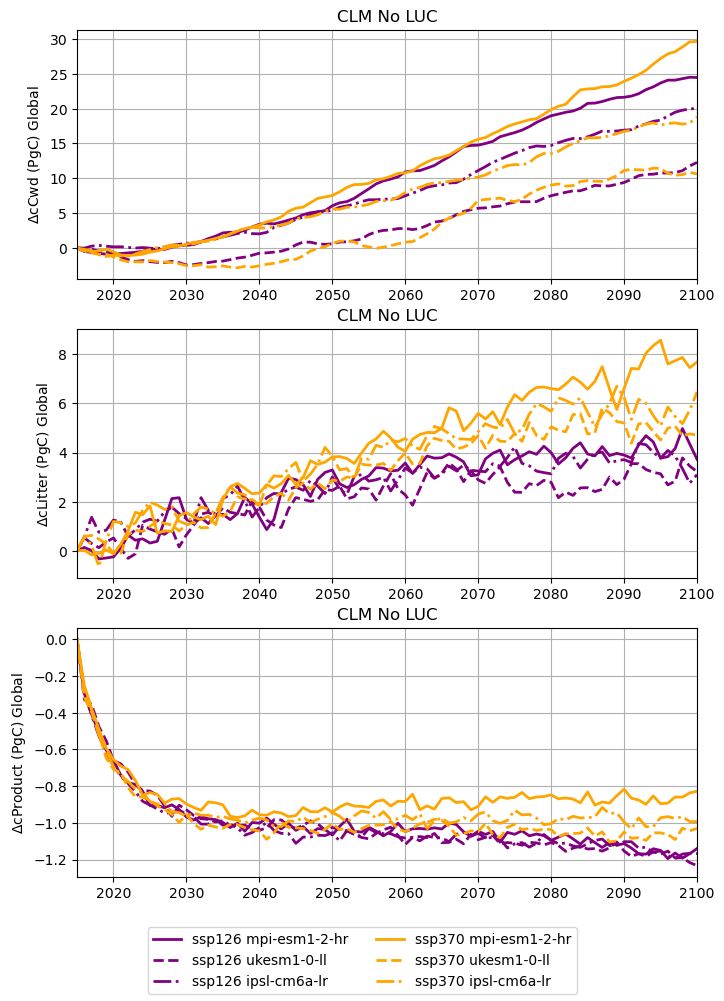

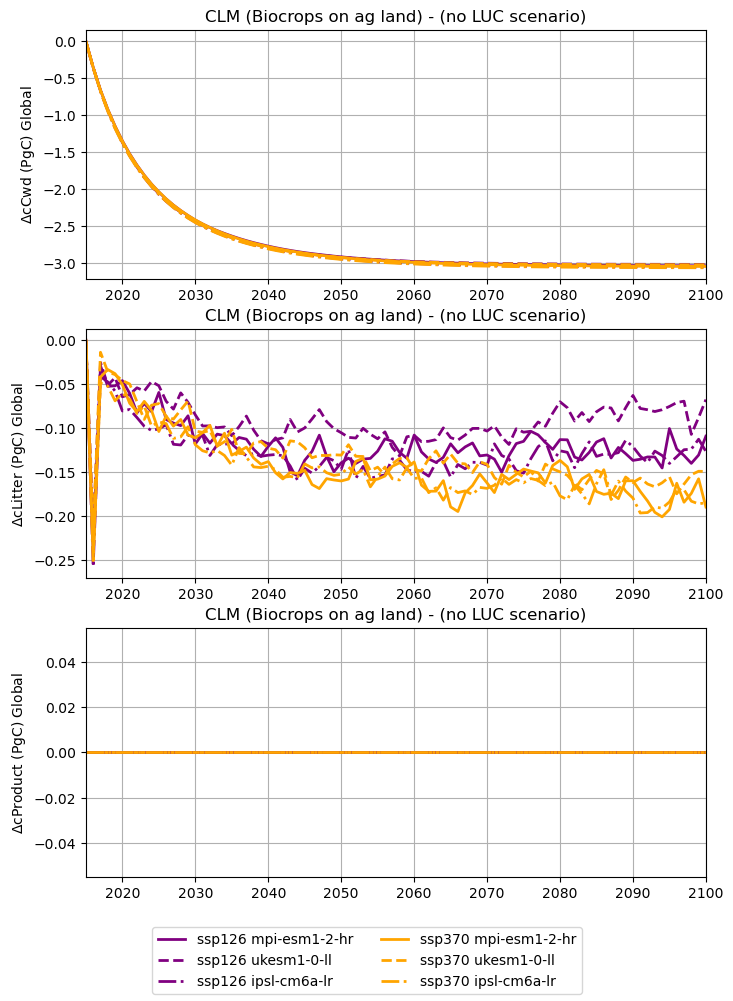

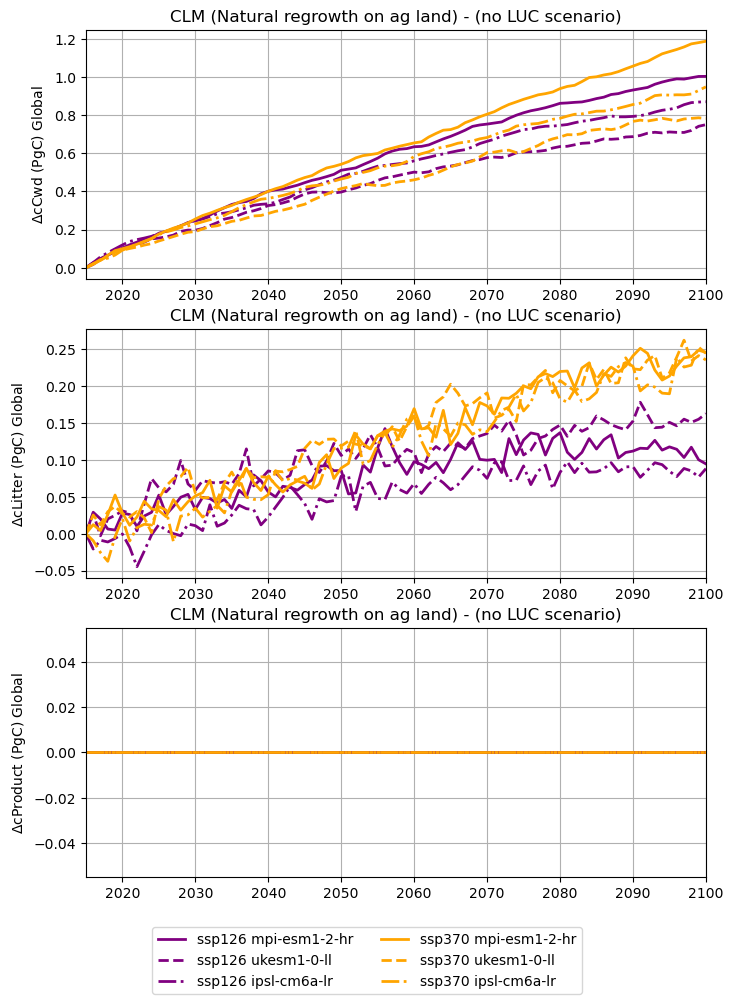

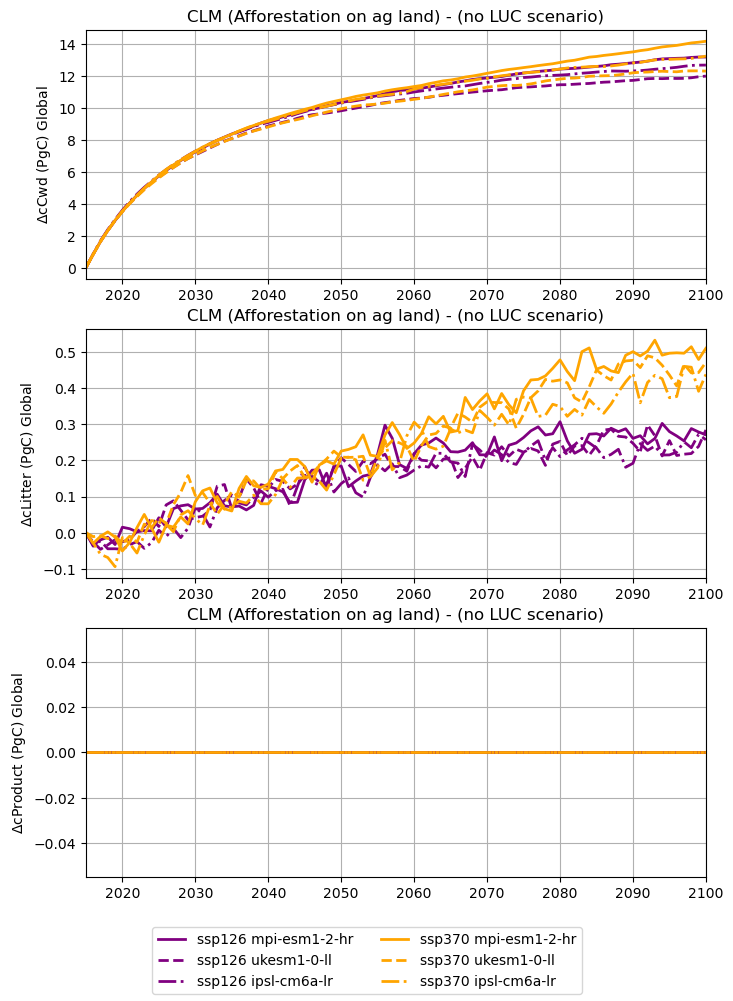

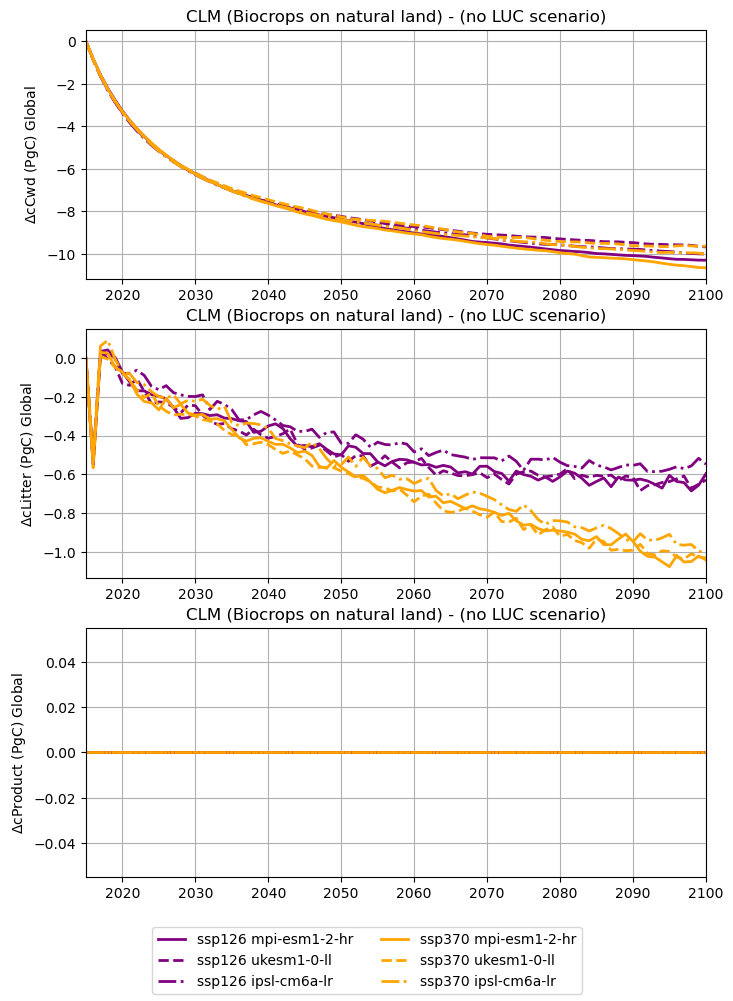

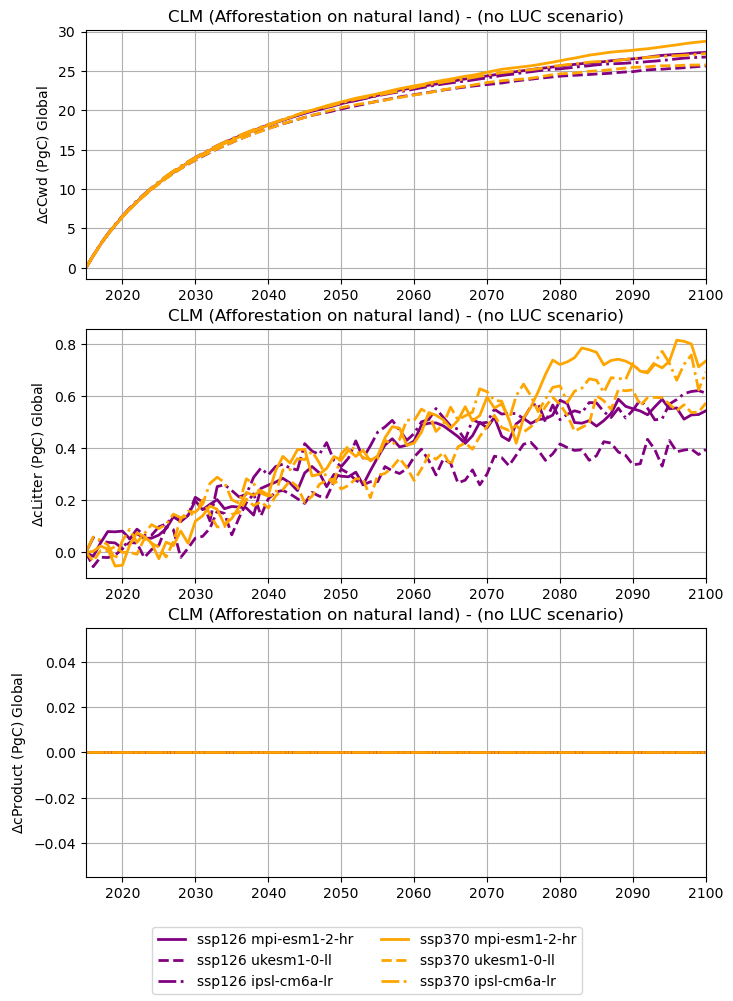

In [56]:
if __name__ == "__main__":
    main()

    